In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import uniform
from scipy.stats import expon
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
fig_size=[]
fig_size.append(15)
fig_size.append(9)
plt.rcParams["figure.figsize"] = fig_size


# We want to estimate the divergence time between *Homo sapiens* and *Pan paniscus* (Bonobo), based on their mitochondrial sequences
We know there are 1347 sites out of 15988 that differ between mitochondrial sequences of those two species, based on the comparison between two sequences downloaded from the NCBI.
We also have estimates of substitution rate per base per year in *Columbidae* and *Elephantidae* and between the Chimpanzee and the Gorilla (see earlier questions).
We will build a Bayesian model to incorporate this rate information as a prior on the rate of evolution for our pair, so that we can estimate the date of divergence between Bonobos and Humans.
<font color=red>__Discutez les différences entre inférence Bayésienne et inférence par maximum de vraisemblance.__</font>

# Model for the inference of the age of the ancestor between *Homo sapiens* and *Pan paniscus*
To build a Bayesian model, one needs to define the likelihood $P(D|M)$ with $D$ the data and $M$ the model, and the prior, $P(M)$. The product of those two constitute the unnormalized posterior probability. In the following we will define the priors and the likelihood so that we can compute the unnormalized posterior probability.
Then we will implement a Metropolis MCMC inference algorithm.

## Constructing priors
There are two parameters in our model: the rate of evolution, and the time of divergence. We need to define priors for both.
### Constructing a prior on substitution rate
Based on the rates we have estimated in previous questions, I decide to use a uniform prior on substitution rate between 4 10-9 and 4 10-8.
We want a probability between 0 and 1, so we use the trick below.
<font color=red>__Donnez un autre exemple de distribution a priori qui serait raisonnable selon vous.__</font>

In [2]:
# Function to compute the prior P(M)
def prior_rate (rate):
    return uniform.pdf(rate*1e9, loc=4, scale=36)


### Constructing a prior on divergence time between the two primates
I decide to use a prior on divergence time between 1e4 and 1e8. This is a huge interval designed to be uninformative. In order to do so, it is convenient to put a uniform prior on the log of the divergence time.

In [3]:
mini = 1e4
maxi = 1e8
# Function to compute the prior P(M)
def prior_time (time):
    return uniform.pdf(math.log(time), loc=math.log(mini), scale=math.log(maxi/mini))


## Building of the likelihood $P(D|M)$
The likelihood is $P(D|M)$. Here the data is the number of sites that differ out of all sites that can be compared. According to the Jukes-Cantor model, the probability that a site differs in the two species is $$p_{diff}=3/4(1- exp(-2t\lambda))$$
Since two bases are either different or the same, we have $$p_{same}=1-p_{diff} = 1/4+3/4 exp(-2t\lambda))$$
Therefore, assuming independence among sites, the likelihood of having $k$ sites that differ out of $n$ is: $$P(D|M) = p_{diff}^kp_{same}^{n-k}$$

In [4]:
# Function to compute the likelihood P(D|M)
def likelihood (n_diff, n_same, time, rate):
    expminus2tlambda = math.exp(-2*time*rate)
    p = pow(3/4*(1 -expminus2tlambda), n_diff) * pow(1/4+(3/4)*expminus2tlambda, n_same)
    return p

# It does not scale well, we have to use the log-likelihood
# Function to compute the likelihood P(D|M)
def log_likelihood (n_diff, n_same, time, rate):
    expminus2tlambda = math.exp(-2*time*rate)
    logp = n_diff*math.log(3/4*(1 -expminus2tlambda)) + n_same * math.log(1/4+(3/4)*expminus2tlambda)
    return logp


# Function to compute the un-normalized posterior P(D|M) * P(M)
def unnormalized_posterior (n_diff, n_same, time, rate):
    return likelihood(n_diff, n_same, time, rate) * prior_rate(rate) * prior_time(time)

# Function to compute the un-normalized posterior P(D|M) * P(M)
def unnormalized_log_posterior (n_diff, n_same, time, rate):
    return log_likelihood(n_diff, n_same, time, rate) + math.log(prior_rate(rate)) + math.log(prior_time(time))


# Function to compute the un-normalized posterior P(D|M) * P(M)
def prior (time, rate):
    return prior_rate(rate) * prior_time(time)

def log_prior (time, rate):
    return math.log(prior_rate(rate)) + math.log(prior_time(time))


# Implementing the MCMC algorithm
<font color=red>__Rappelez brièvement à quoi sert l'algorithme MCMC.__</font>

In [5]:
# Function to propose a new rate value, randomly drawn between 4e-09 and 4e-08
def propose_new_rate_value():
    return uniform.rvs(loc=4, scale=36, size=1)[0]/1e9

# Function to propose a new time value, randomly drawn between 1e04 and 1e08
def propose_new_time_value():
    return math.exp(uniform.rvs(loc=math.log(mini), scale=math.log(maxi/mini), size=1)[0])


# Function to run Metropolis MCMC inference
def MetropolisMCMC(n_diff, n_same, number_iterations, prior_only):
    current_rate_value = propose_new_rate_value()
    record_rate_parameter = []
    record_rate_parameter.append(current_rate_value)
    current_time_value = propose_new_time_value()
    record_time_parameter = []
    record_time_parameter.append(current_time_value)
    print("Initial rate value for the MCMC: "+str(current_rate_value))
    print("Initial time value for the MCMC: "+str(current_time_value))
    current_posterior = 0.0
    if not prior_only:
        current_posterior = unnormalized_log_posterior(n_diff, n_same, current_time_value, current_rate_value)
    else:
        current_posterior = log_prior(current_time_value, current_rate_value) 
    print("Initial probability of the model: " + str(current_posterior))
    record_posterior = []
    record_posterior.append(current_posterior)
    for i in range (number_iterations):
        acceptance_threshold = random.random()
        proposed_rate_value = propose_new_rate_value()
        proposed_time_value = propose_new_time_value()
        proposed_posterior = 0.0
        if (not prior_only):
            proposed_posterior = unnormalized_log_posterior(n_diff, n_same, proposed_time_value, proposed_rate_value)
        else:
            proposed_posterior = log_prior(proposed_time_value, proposed_rate_value) 
        if (proposed_posterior > current_posterior or math.exp(proposed_posterior - current_posterior) > acceptance_threshold):
            current_rate_value = proposed_rate_value
            current_time_value = proposed_time_value
            current_posterior = proposed_posterior
        record_rate_parameter.append(current_rate_value)
        record_time_parameter.append(current_time_value)
        record_posterior.append(current_posterior)
    return record_rate_parameter, record_time_parameter, record_posterior


# Running the Metropolis MCMC on the data
First, we run the MCMC with the data, then we run the MCMC without considering the data, so that we can compare the two results.
<font color=red>__Expliquez pourquoi il est important de comparer les résultats obtenus en utilisant les données aux résultats obtenus en se basant seulement sur les distributions a priori.__</font>

In [6]:
# Running with the data: inference of the posterior
rate_params, time_params, posteriors = MetropolisMCMC(1347,15988-1347, 50000, False)

Initial rate value for the MCMC: 2.57961403735e-08
Initial time value for the MCMC: 92558500.26508464
Initial probability of the model: -20335.55549565211


In [7]:
# Running under the prior only, without data
rate_params_prior, time_params_prior, posteriors_prior = MetropolisMCMC(1347, 15988-1347, 20000, True)

Initial rate value for the MCMC: 1.38223145638e-08
Initial time value for the MCMC: 1681269.2581115726
Initial probability of the model: -5.803845744823956


#  Analysis of the run to sample from the posterior

#### Posterior probability across iterations of the MCMC run

Text(0,0.5,'Posterior probability')

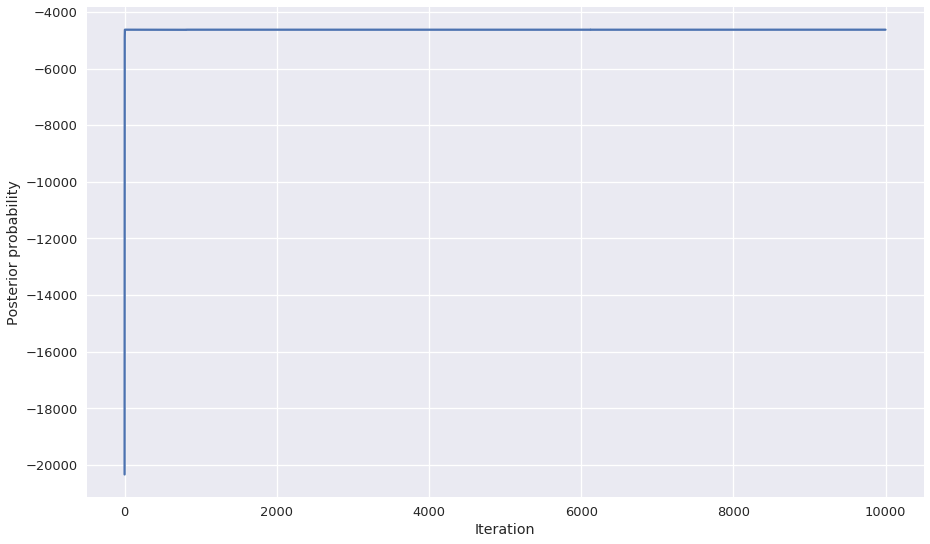

In [8]:
plt.plot(posteriors[0::5])
plt.xlabel("Iteration")
plt.ylabel("Posterior probability")


#### Rate parameter value across iterations of the MCMC run

Text(0,0.5,'Rate parameter value')

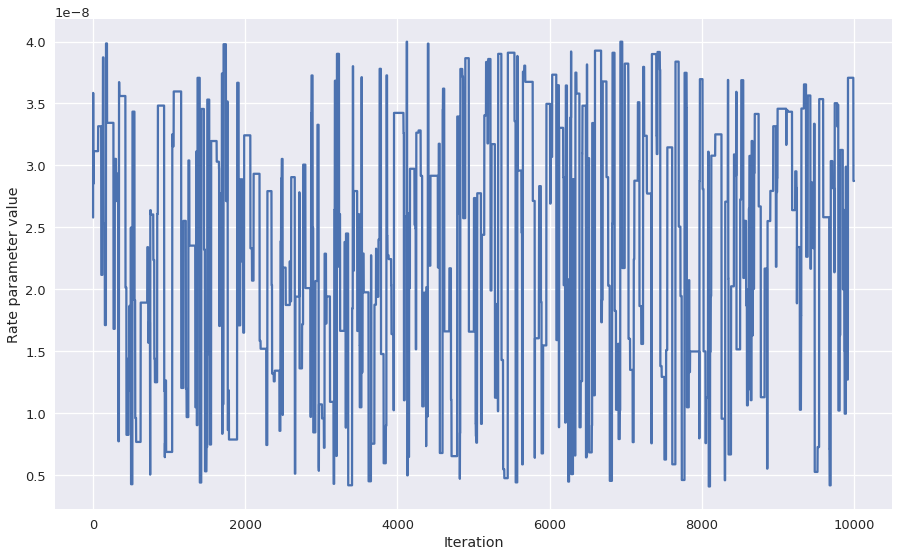

In [9]:
plt.plot(rate_params[0::5])
plt.xlabel("Iteration")
plt.ylabel("Rate parameter value")


#### Time parameter value across iterations of the MCMC run

Text(0,0.5,'Time parameter value')

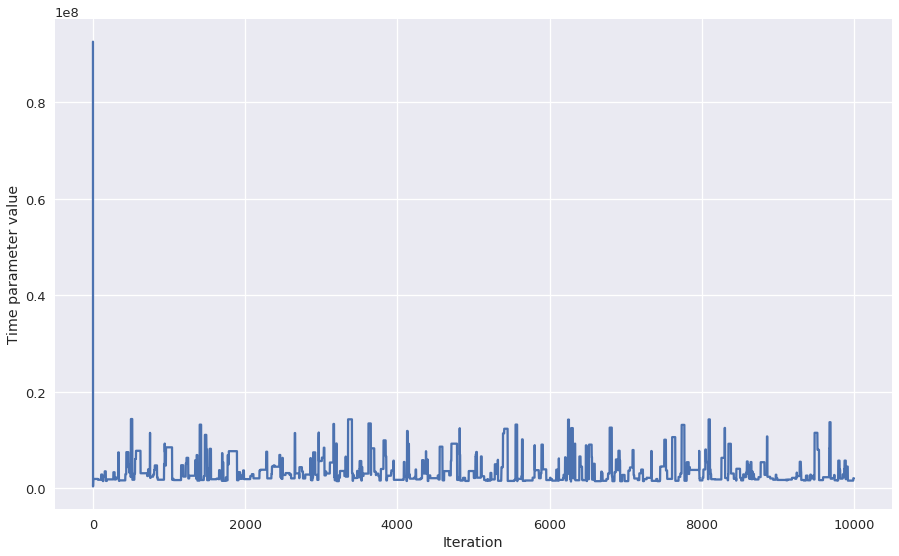

In [10]:
plt.plot(time_params[0::5])
plt.xlabel("Iteration")
plt.ylabel("Time parameter value")


<font color=red>__Commentez brièvement les trois graphes ci-dessus.__</font>

# Let's compare the divergence time inferred according to the posterior to that obtained according to the prior only

<font color=red>__Pourquoi est-il important de comparer la distribution a posteriori de la distribution a priori?__</font>

Text(0,0.5,'Density/Frequency')

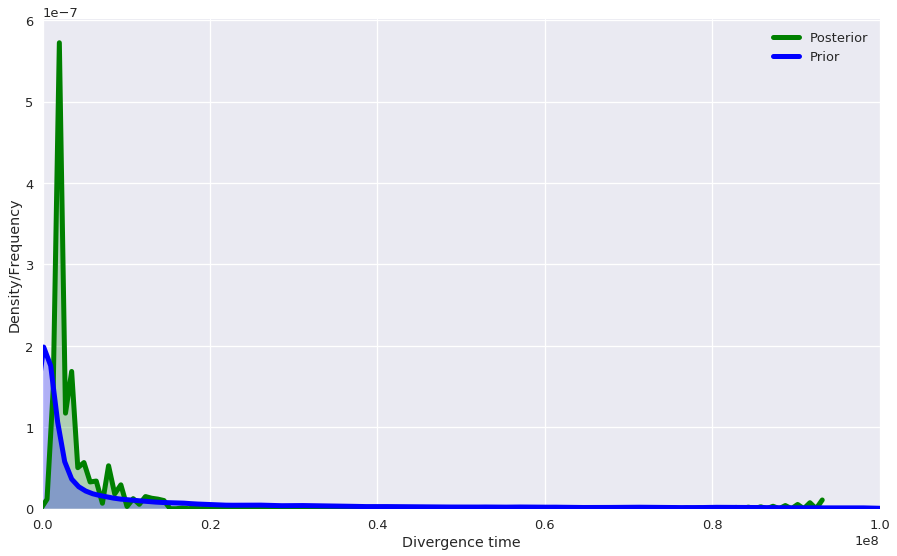

In [16]:
axes = plt.gca()
axes.set_xlim([mini,maxi])

sns.kdeplot(np.array(time_params), lw=5, color="green", shade=True, legend=True, label="Posterior")
sns.kdeplot(np.array(time_params_prior), lw=5, color="blue", shade=True, legend=True, label="Prior")
plt.legend()
plt.xlabel("Divergence time")
plt.ylabel("Density/Frequency")


### Our median estimate for the time of divergence is:

In [12]:
median_param_time=np.median(time_params)
print("Median time estimate from the posterior: ")
print(str(median_param_time))

print("Compared to the prior: ")
median_param_time_prior=np.median(time_params_prior)
print(str(median_param_time_prior))


Median time estimate from the posterior: 
2332709.60102
Compared to the prior: 
994788.30227


### Let's compute a 95% credibility interval on the divergence time

In [13]:
def HDI_from_MCMC(posterior_samples, credible_mass):
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)

print("95% credibility interval from the posterior: ")
print(HDI_from_MCMC(time_params, 0.95))
print("Compared to the interval from the prior: ")
print(HDI_from_MCMC(time_params_prior, 0.95))


95% credibility interval from the posterior: 
(1461327.337593627, 10064350.603588909)
Compared to the interval from the prior: 
(10005.831626748724, 63251502.846556544)


<font color=red>__Discutez les résultats ci-dessus : y-a-t-il une différence entre les valeurs obtenues avec (posterior) ou sans données (prior seulement) ?


Quelle estimation de la date de divergence pouvez-vous donner ? Pour comparaison, le site http://www.timetree.org/, qui s'appuie sur la littérature scientifique pour donner les dates de divergences entre espèces, donne une date de divergence d'environ 6.4Mya entre Bonobo et homme.


Proposez des façons d'améliorer l'analyse Bayésienne ci-dessus.__</font>
